## Bibliotecas Utilizadas

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import regex as re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from operator import itemgetter

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from datetime import datetime, time
import seaborn as sns
import squarify

In [2]:
print ("Início Execução : ")
print (datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Início Execução : 
2021-04-23 18:21:27


In [3]:
# stopwords e simbolos a retirar
stop_words_portugues = set(['co','de','a','o','que','e','é','do','da','em','um','para','com','não','uma','os','no','se','na','por','mais','as','dos','como','mas','ao','ele','das','à','seu','sua','ou','quando','muito','nos','já','eu','também','só','pelo','pela','até','isso','ela','entre','depois','sem','mesmo','aos','seus','quem','nas','me','esse','eles','você','essa','num','nem','suas','meu','às','minha','numa','pelos','elas','qual','nós','lhe','deles','essas','esses','pelas','este','dele','tu','te','vocês','vos','lhes','meus','minhas','teu','tua','teus','tuas','nosso','nossa','nossos','nossas','dela','delas','esta','estes','estas','aquele','aquela','aqueles','aquelas','isto','aquilo','estou','está','estamos','estão','estive','esteve','estivemos','estiveram','estava','estávamos','estavam','estivera','estivéramos','esteja','estejamos','estejam','estivesse','estivéssemos','estivessem','estiver','estivermos','estiverem','hei','há','havemos','hão','houve','houvemos','houveram','houvera','houvéramos','haja','hajamos','hajam','houvesse','houvéssemos','houvessem','houver','houvermos','houverem','houverei','houverá','houveremos','houverão','houveria','houveríamos','houveriam','sou','somos','são','era','éramos','eram','fui','foi','fomos','foram','fora','fôramos','seja','sejamos','sejam','fosse','fôssemos','fossem','for','formos','forem','serei','será','seremos','serão','seria','seríamos','seriam','tenho','tem','temos','tém','tinha','tínhamos','tinham','tive','teve','tivemos','tiveram','tivera','tivéramos','tenha','tenhamos','tenham','tivesse','tivéssemos','tivessem','tiver','tivermos','tiverem','terei','terá','teremos','terão','teria','teríamos','teriam'])
stop_words_ingles = set(stopwords.words('english'))
stop_words_espanhol = set(stopwords.words('spanish'))
symbols = set(['-', 'r$', 'R$', '.', '|'])

In [4]:
# Function to remove emoji.
def emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [5]:
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTópico #{}:".format(index)
        message += ", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [6]:
def tweet_tokenizer(text):
    tweet = text.lower()
    tweet_token = [w for w in re.split('\W+', tweet) if not w in (stop_words_portugues | stop_words_espanhol | stop_words_ingles | symbols)]
    tweet_token = [w for w in tweet_token if re.match(r'http*', w) == None]
    tweet_token = [w for w in tweet_token if not (w.startswith('@') | w.startswith('#'))]
    tweet_token = [w for w in tweet_token if w != 'rt']
        
    return emoji(" ".join(tweet_token))

# Carregando os dados 

In [7]:
# Dataframe com todos os politicos e seus tweets
lista_dir = os.listdir("./politicos/")
nome_politicos = []
df_politicos = pd.DataFrame()
for nome in lista_dir:
    df_politico = pd.read_csv(
        f"./politicos/{nome}",
        delimiter=",",
        encoding='utf-8',
        usecols=[1,2,8]
    )
    df_politico['nome'] = nome[:-4]
    nome_politicos.append(nome[:-4])
    df_politicos = df_politicos.append(df_politico)
    cols = ['nome'] + [col for col in df_politicos if col != 'nome']
    df_politicos = df_politicos[cols]

In [8]:
df_politicos.head(10)

,nome,created_at,text,id
0,Amoedo,2021-04-19T16:18:20Z,RT @MBLivre: Presidente americano Joe Biden an...,1384179569712713735
1,Amoedo,2021-04-19T16:05:53Z,Temos que fazer a nossa parte. Não podemos dei...,1384176435552608259
2,Amoedo,2021-04-19T15:32:40Z,O governo federal e o Congresso ignoraram no O...,1384168077697314825
3,Amoedo,2021-04-19T12:53:14Z,RT @o_antagonista: .@joaoamoedonovo sugeriu no...,1384127951311040517
4,Amoedo,2021-04-19T12:25:58Z,Informações de @OGloboPolitica,1384121090243383296
5,Amoedo,2021-04-19T12:19:42Z,A CPI da Pandemia no Senado deve investigar o ...,1384119514418216969
6,Amoedo,2021-04-18T19:21:07Z,Leia a coluna completa em https://t.co/rvNDUpnqgA,1383863178853969921
7,Amoedo,2021-04-18T19:21:06Z,"""Membros do Executivo e do Legislativo não ace...",1383863176891015168
8,Amoedo,2021-04-18T15:42:35Z,Informações de @RevistaEpoca,1383808183223734272
9,Amoedo,2021-04-18T15:42:25Z,O governo federal gastará R$500 mil em uma cam...,1383808141897342986


In [9]:
df_politicos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31633 entries, 0 to 1294
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   nome        31633 non-null  object
 1   created_at  31633 non-null  object
 2   text        31633 non-null  object
 3   id          31633 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


## LDA - Latent Dirichlet Allocation - Modelagem de Tópicos

In [63]:
df_politicos['tweet_token'] = df_politicos['text'].apply(tweet_tokenizer)
df_politicos.head()

,nome,created_at,text,id,tweet_token,Topico
0,Amoedo,2021-04-19T16:18:20Z,RT @MBLivre: Presidente americano Joe Biden an...,1384179569712713735,mblivre presidente americano joe biden anuncia...,20
1,Amoedo,2021-04-19T16:05:53Z,Temos que fazer a nossa parte. Não podemos dei...,1384176435552608259,fazer parte podemos deixar brasil continuar an...,16
2,Amoedo,2021-04-19T15:32:40Z,O governo federal e o Congresso ignoraram no O...,1384168077697314825,governo federal congresso ignoraram orçamento ...,1
3,Amoedo,2021-04-19T12:53:14Z,RT @o_antagonista: .@joaoamoedonovo sugeriu no...,1384127951311040517,o_antagonista joaoamoedonovo sugeriu twitter t...,9
4,Amoedo,2021-04-19T12:25:58Z,Informações de @OGloboPolitica,1384121090243383296,informações oglobopolitica,9


In [14]:
tf_vectorizer = CountVectorizer(analyzer='word',       
                                min_df=10,                        # minimo de 10 ocorrencias para entrar na matriz
                                token_pattern='[a-zA-Z0-9]{3,}')  # palavras com mais de 3 letras serão consideradas)

tf = tf_vectorizer.fit_transform(list(df_politicos['tweet_token']))
                                
# Materialize the sparse data
data_dense = tf.todense()

print("% Esparsa: ", round(((data_dense > 0).sum()/data_dense.size)*100, 2), "%")

% Esparsa:  0.21 %


In [45]:
lda = LatentDirichletAllocation(n_components=10, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                learning_decay = 0.9,
                                random_state = 50)
lda_output = lda.fit_transform(tf)

In [16]:
# Probabilidade logaritmica: quanto maior melhor
print("probabilidade logaritmica: ", round(lda.score(tf), 2))

# Perplexidade: menor melhor.  exp(-1. * log-Probabilidade logaritmica por palavra)
print("Perplexidade: ", round(lda.perplexity(tf), 2))

print("Parâmetros:")
print(lda.get_params())

probabilidade logaritmica:  -3431026.06
Perplexidade:  3093.19
Parâmetros:
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.9, 'learning_method': 'online', 'learning_offset': 50.0, 'max_doc_update_iter': 100, 'max_iter': 5, 'mean_change_tol': 0.001, 'n_components': 22, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 50, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [17]:
# Define Search Param
search_params = {'n_components':[22, 33, 44, 55, 66], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(tf)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [22, 33, 44, 55, 66]})

In [18]:
# Melhor modelo
best_lda_model = model.best_estimator_

# Hiperparâmetros do modelo
print("Melhores parâmetros: ", model.best_params_)

# probabilidade logarítmica
print("Melhor score de probabilidade logarítmica: ", model.best_score_)

# Perplexidade
print("Perplexidade do modelo: ", best_lda_model.perplexity(tf))

Melhores parâmetros:  {'learning_decay': 0.7, 'n_components': 22}
Melhor score de probabilidade logarítmica:  -837069.97516664
Perplexidade do modelo:  2537.1278391739875


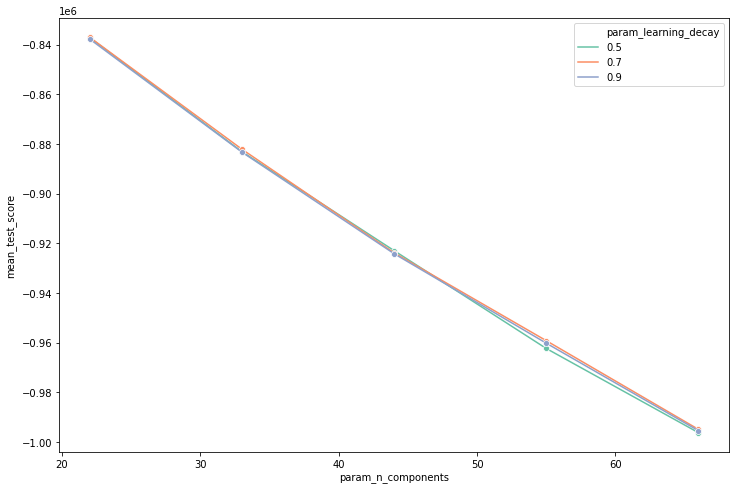

In [19]:
results = pd.DataFrame(model.cv_results_)

current_palette = sns.color_palette("Set2", 3)

plt.figure(figsize=(12,8))

sns.lineplot(data=results,
             x='param_n_components',
             y='mean_test_score',
             hue='param_learning_decay',
             palette=current_palette,
             marker='o'
            )

plt.show()

In [20]:
# Create Document - Topic Matrix
lda_output = lda.transform(tf)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df_politicos))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.style.applymap(color_green).applymap(make_bold)
df_document_topics_first10 = df_document_topic[:10].style.applymap(color_green).applymap(make_bold)
df_document_topics_first10

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,dominant_topic
Doc0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.710000,0.000000,20
Doc1,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.860000,0.010000,0.010000,0.010000,0.010000,0.010000,16
Doc2,0.120000,0.590000,0.130000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.130000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
Doc3,0.300000,0.010000,0.010000,0.010000,0.010000,0.130000,0.010000,0.010000,0.010000,0.310000,0.010000,0.010000,0.010000,0.010000,0.170000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,9
Doc4,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.520000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,9
Doc5,0.190000,0.190000,0.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.530000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10
Doc6,0.010000,0.010000,0.010000,0.260000,0.010000,0.510000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,5
Doc7,0.000000,0.000000,0.310000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.550000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,13
Doc8,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.350000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.350000,0.020000,0.020000,0.020000,0.020000,9
Doc9,0.180000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.320000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.370000,0.100000,20


In [21]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,4,2544
1,21,2193
2,5,2186
3,0,2095
4,16,2081
5,20,1902
6,15,1685
7,12,1525
8,6,1308
9,8,1280


In [22]:
n_top_words = 5
print("\nTópicos no Modelo LDA: ")
print("*"*70)
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(best_lda_model, tf_feature_names, n_top_words)


Tópicos no Modelo LDA: 
**********************************************************************

Tópico #0:rios, ser, cidad, deve, rio

Tópico #1:lio, aux, emergencial, crime, lei

Tópico #2:bilh, rio, bolsonaro, anos, governo

Tópico #3:brasil, ria, gente, bolsonaro, ter

Tópico #4:dia, caldeir, obrigado, bom, sempre

Tópico #5:ncia, lula, presidente, democracia, novo

Tópico #6:ria, econ, servi, rio, renda

Tópico #7:educa, hoje, rede, blica, ensino

Tópico #8:vacina, brasil, nacional, butantan, vacinas

Tópico #9:governosp, imprensa, vivo, redes, acompanhe

Tópico #10:mil, milh, fam, lias, brasileiros

Tópico #11:ind, nia, amaz, genas, cil

Tópico #12:rus, coronav, pandemia, vidas, covid

Tópico #13:ncia, vel, blica, apoio, reuni

Tópico #14:vacinar, vou, leitos, uti, amigos

Tópico #15:munic, pios, regi, milh, govbr

Tópico #16:pol, tica, ria, ncia, ser

Tópico #17:novo, hoje, rio, dio, debate

Tópico #18:dias, not, cia, pre, cias

Tópico #19:vamosriogrande, boa, borafazerrs, dia, 

In [23]:
df2 = pd.DataFrame(data=df_document_topics.data, columns=df_document_topics.columns)
df2.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,dominant_topic
Doc0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.10,0.00,...,0.11,0.00,0.00,0.00,0.00,0.00,0.00,0.71,0.00,20
Doc1,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.86,0.01,0.01,0.01,0.01,0.01,16
Doc2,0.12,0.59,0.13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
Doc3,0.30,0.01,0.01,0.01,0.01,0.13,0.01,0.01,0.01,0.31,...,0.01,0.17,0.01,0.01,0.01,0.01,0.01,0.01,0.01,9
Doc4,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.52,...,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,9


In [50]:
df_politicos["Topico"] = df2["dominant_topic"].tolist()
df_politicos.head()

,nome,created_at,text,id,tweet_token,Topico
0,Amoedo,2021-04-19T16:18:20Z,RT @MBLivre: Presidente americano Joe Biden an...,1384179569712713735,mblivre presidente americano joe biden anuncia...,20
1,Amoedo,2021-04-19T16:05:53Z,Temos que fazer a nossa parte. Não podemos dei...,1384176435552608259,fazer parte podemos deixar brasil continuar an...,16
2,Amoedo,2021-04-19T15:32:40Z,O governo federal e o Congresso ignoraram no O...,1384168077697314825,governo federal congresso ignoraram orçamento ...,1
3,Amoedo,2021-04-19T12:53:14Z,RT @o_antagonista: .@joaoamoedonovo sugeriu no...,1384127951311040517,o_antagonista joaoamoedonovo sugeriu twitter t...,9
4,Amoedo,2021-04-19T12:25:58Z,Informações de @OGloboPolitica,1384121090243383296,informações oglobopolitica,9


In [51]:
df_politicos.groupby(["Topico"])['nome'].agg(pd.Series.mode).to_frame()

C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.d

,nome
Topico,
0,Amoedo
1,Moro
2,Amoedo
3,Huck
4,Huck
5,Lula
6,Leite
7,Leite
8,Doria


In [54]:
df_politicos[df_politicos["Topico"]==4].groupby(["nome"]).size().sort_values(ascending=False)[:5]

C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.d

nome
Huck         1415
Ciro          312
Lula          234
Marina        118
Bolsonaro     112
dtype: int64

In [55]:
df_politicos[df_politicos["Topico"]==21].groupby(["nome"]).size().sort_values(ascending=False)[:5]

C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.d

nome
Boulos    1419
Ciro       238
Lula       210
Doria      100
Huck        75
dtype: int64

In [56]:
df_politicos[df_politicos["Topico"]==5].groupby(["nome"]).size().sort_values(ascending=False)[:5]

C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.d

nome
Lula      891
Amoedo    368
Marina    285
Moro      129
Boulos    117
dtype: int64

In [57]:
df_politicos[df_politicos["Topico"]==0].groupby(["nome"]).size().sort_values(ascending=False)[:5]

C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.d

nome
Amoedo       566
Mandetta     262
Bolsonaro    210
Huck         208
Leite        183
dtype: int64

In [58]:
df_politicos[df_politicos["Topico"]==16].groupby(["nome"]).size().sort_values(ascending=False)[:5]

C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.d

nome
Marina    615
Amoedo    226
Ciro      220
Lula      205
Huck      186
dtype: int64

In [59]:
df_politicos[df_politicos["Topico"]==5].groupby(["nome"]).size().sort_values(ascending=False)[:5]

C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.d

nome
Lula      891
Amoedo    368
Marina    285
Moro      129
Boulos    117
dtype: int64

In [60]:
df_politicos[df_politicos["Topico"]==9].groupby(["nome"]).size().sort_values(ascending=False)[:5]

C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.d

nome
Lula         349
Doria        341
Bolsonaro    121
Ciro          90
Mandetta      76
dtype: int64

In [61]:
df_politicos[df_politicos["Topico"]==10].groupby(["nome"]).size().sort_values(ascending=False)[:5]

C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.d

nome
Bolsonaro    345
Amoedo       181
Boulos       146
Ciro         138
Doria        130
dtype: int64

In [62]:
df_politicos[df_politicos["Topico"]==15].groupby(["nome"]).size().sort_values(ascending=False)[:5]

C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.d

nome
Bolsonaro    829
Leite        345
Doria        211
Mandetta      80
Marina        62
dtype: int64

In [31]:
import pyLDAvis.sklearn
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

In [47]:
#pyLDAvis.enable_notebook()
#dash = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer, mds = 'tsne')
#dash
print(1)

1


In [33]:
print ("Fim Execução : ")
print (datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Fim Execução : 
2021-04-23 19:21:51


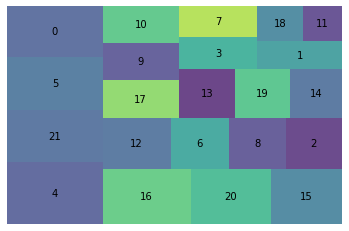

In [68]:
squarify.plot(sizes=df_topic_distribution['Num Documents'], label=df_topic_distribution['Topic Num'], alpha=.8 )
plt.axis('off')
plt.show()

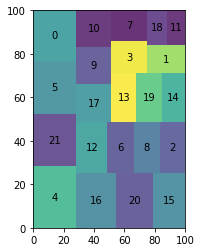

C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.d

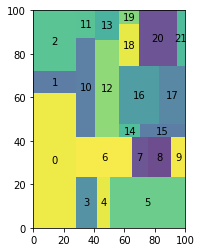

C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.d

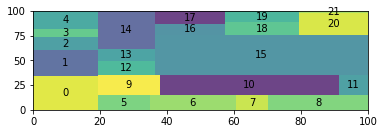

C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.d

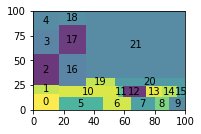

C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.d

ValueError: num must be 1 <= num <= 3, not 4

<Figure size 432x288 with 0 Axes>

In [89]:
# treemap por politico
xc = 1
yc = 1
plt.subplot(1, 2, 1)
squarify.plot(sizes=df_topic_distribution['Num Documents'], label=df_topic_distribution['Topic Num'], alpha=.8)
plt.show()

for idx in range(11):
    dfTopicos = df_politicos[df_politicos["nome"]==nome_politicos[idx]].groupby(["Topico"]).size().to_frame().reset_index("Topico")
    dfTopicos.columns = ['Topico', 'Quantidade']
    yc += 1
    if (yc > 2):
        yc = 1
        xc += 1
        if (xc >= 6):
            xc = 1    
    plt.subplot(xc, yc, idx+1)
    squarify.plot(sizes=dfTopicos['Quantidade'], label=dfTopicos['Topico'], alpha=.8 )
    plt.show()

<AxesSubplot:>

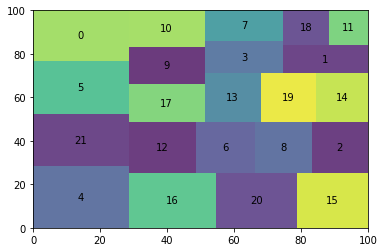

In [83]:
squarify.plot(sizes=df_topic_distribution['Num Documents'], label=df_topic_distribution['Topic Num'], alpha=.8)